DRAFT  -needs edits
==========
run the cells from login node for a static version 


Running Jobs
===============

Accessing the Compute Nodes
-------------------------------

Delta implements the Slurm batch environment to manage access to the compute nodes. 
Use the Slurm commands to run batch jobs or for interactive access to compute nodes. 
See: https://slurm.schedmd.com/quickstart.html for an introduction to Slurm. 
There are multiple ways to access compute nodes on Delta.

Batch scripts (sbatch) or Interactive (srun , salloc) , which is right for me?

- `sbatch` . Use batch scripts for jobs that are debugged, ready to run, and don't require interaction.
  Sample Slurm batch job scripts are provided in the :ref:`examples` section.
  For mixed resource heterogeneous jobs see: https://slurm.schedmd.com/heterogeneous_jobs.html#submitting. 
  Slurm also supports job arrays for easy management of a set of similar jobs, see:   https://slurm.schedmd.com/job_array.html.

- `srun` . For interactive use of a compute node, srun will run a single command through slurm on a compute node. srun blocks, it will wait until slurm has scheduled compute resources and when it returns, the job is complete.

- `salloc` . Also interactive, use salloc when you want to reserve compute resources for a period of time and interact with them using multiple commands.  Each command you type after your salloc session begins will run : on the login node if it is just a normal command, or on your reserved compute resources if prefixed with srun.  Type "exit" when finished with an salloc allocation if you want to end it before the time expires.


Direct SSH access to a compute node in a running job from a dt-loginNN node is enabled once the job has started:

In [ ]:
!squeue -u $USER

In [ ]:
!ssh gpub046 uptime

Scheduler
-------------

For information, see the Slurm quick reference guide: https://slurm.schedmd.com/quickstart.html

Partitions (Queues)
-----------------------

Delta Production Default Partition Values
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

======================= ==================
Property                Value
======================= ==================
Default Memory per core 1000 MB
Default Wall-clock time 30 minutes
======================= ==================

Delta Production Partitions/Queues
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sview View of Slurm Partitions
------------------------------


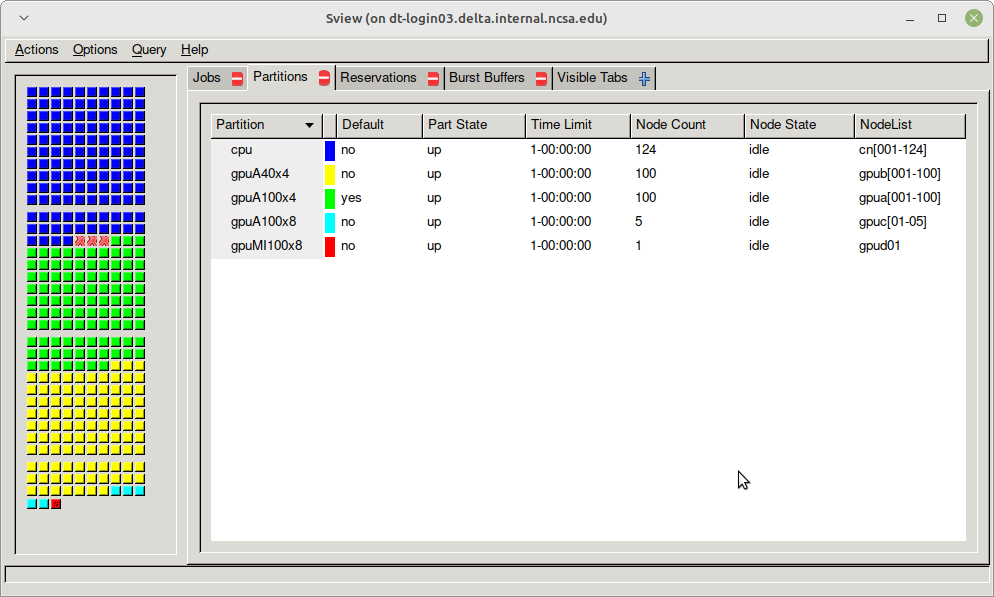

Node Policies
-------------

Node-sharing is the default for jobs. 
Node-exclusive mode can be obtained by specifying all the consumable resources for that node type or adding the following Slurm options:

    --exclusive --mem=0

GPU NVIDIA MIG (GPU slicing) for the A100 will be supported at a future date.

Pre-emptive jobs will be supported at a future date.

Job Policies
----------------

The default job requeue or restart policy is set to not allow jobs to be automatically requeued or restarted (as of 12/19/2022).
To enable automatic requeue and restart of a job by Slurm, please add the following Slurm directive:

    --requeue 

When a job is requeued due to an event like a node failure, the batch script is initiated from its beginning. 
Job scripts need to be written to handle automatically restarting from checkpoints.

Job Management
-----------------

sbatch
------

Batch jobs are submitted through a *job script* (as in the `examples`) using the sbatch command. 
Job scripts generally start with a series of Slurm *directives* that describe requirements of the job, such as number of nodes and wall time required, to the batch system/scheduler (Slurm directives can also be specified as options on the sbatch command line; command line options take precedence over those in the script). 
The rest of the batch script consists of user commands.

The syntax for sbatch is: **sbatch** [list of sbatch options] script_name. Refer to the sbatch man page for detailed information on the options.


    $ sbatch tensorflow_cpu.slurm
    Submitted batch job 2337924
    $ squeue -u $USER
         JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
        2337924 cpu-inter    tfcpu  mylogin  R       0:46      1 cn006

In [ ]:
!cd /projects/bbka/slurm_test_scripts/cpu/stream; sbatch stream.slurm

squeue/scontrol/sinfo
---------------------

Commands that display batch job and partition information.

srun
-----

The **srun** command initiates an interactive job or process on compute nodes.

For example, the following command will run an interactive job in the gpuA100x4 or gpuA40x4 partition with a wall-clock time limit of 30 minutes, using one node and 16 cores per node and 1 GPU:

.. code-block::

   srun -A account_name --time=00:30:00 --nodes=1 --ntasks-per-node=16 \
   --partition=gpuA100x4,gpuA40x4 --gpus=1 --mem=16g --pty /bin/bash

After you enter the command, wait for Slurm to start the job. 
As with any job, your interactive job is queued until the specified number of nodes is available. 
If you specify a small number of nodes for smaller amounts of time, the wait should be shorter because your job will backfill among larger jobs. 
You will see something like this:


In [ ]:
!srun --mem=16g --nodes=1 --ntasks-per-node=1 --cpus-per-task=4 \
   --partition=gpuA100x4-interactive,gpuA40x4-interactive --account=bbka-delta-gpu \
   --gpus-per-node=1 --time=00:30:00 --x11 --pty /bin/bash

In [ ]:
%%bash
uptime    # clean this away but use for salloc
hostname
srun --mem=16g --nodes=1 --ntasks-per-node=1 --cpus-per-task=4 \
   --partition=gpuA100x4-interactive,gpuA40x4-interactive --account=bbka-delta-gpu \
   --gpus-per-node=1 --time=00:30:00  /bin/bash

When finished, use the ``exit`` command to end the bash shell on the compute resource and hence the slurm srun job.

salloc
------

While being interactive like srun, salloc allocates compute resources for you, while leaving your shell on the login node.  Run commands on the login node as usual, use "exit" to end an salloc session early, and use srun with no extra flags to launch processes on the compute resources.


In [ ]:
%%bash
salloc --mem=16g --nodes=1 --ntasks-per-node=1 --cpus-per-task=2 \
     --partition=gpuA40x4-interactive,gpuA100x4-interactive \
     --account=bbka-delta-gpu --time=00:30:00 --gpus-per-node=1
cd /projects/bbka/slurm_test_scripts/gpu/cuda/cuda-samples/bin/x86_64/linux/release
pwd
srun ./bandwidthTest 
exit

scancel
-------

The scancel command deletes a queued job or terminates a running job. The example below deletes/terminates the job with the associated JobID.

    scancel JobID 

Job Status
----------

If the NODELIST(REASON) is MaxGRESPerAccount, that means that a user has exceeded the number of cores or GPUs allotted per user or project for a given partition.

Useful Batch Job Environment Variables
-------------------------------------

Monitoring a Node During a Job
---------------------------------

You have SSH access to nodes in your running job(s). Some of the basic monitoring tools are demonstrated in the example transcript below. Screen shots are appended so that you can see the output from the tools. Most common Linux utilities are available from the compute nodes (free, strace, ps, and so on).

Here's an example showing the use of "top" to see what is running on a node with a job in progress.

In [ ]:
%%bash
salloc \
 --mem=16g \
 --nodes=1 \
 --ntasks-per-node=1 \
 --cpus-per-task=2 \
 --partition=cpu-interactive \
 --account=bbka-delta-cpu \
 --time=00:30:00
 
 squeue -u $USER
 MYCOMPUTENODE=`squeue -u $USER --noheader --Format=NodeList | tail -1`
 echo MYCOMPUTENODE=${MYCOMPUTENODE} ----------------------------
 ssh ${MYCOMPUTENODE} top -u $USER -b -n 1
 

Interactive X11 Support
------------------------------

To run an X11 based application on a compute node in an interactive session, the use of the ``--x11`` switch with ``srun`` is needed. 
For example, to run a single core job that uses 1G of memory with X11 (in this case an xterm) do the following:

    srun -A abcd-delta-cpu  --partition=cpu-interactive \
        --nodes=1 --tasks=1 --tasks-per-node=1 \
        --cpus-per-task=2 --mem=16g \
        --x11  xterm


File System Dependency Specification for Jobs
---------------------------------------------

Please see the `depend_arch` section in System Architecture for information on setting job file system dependencies for jobs.

Jobs that do not specify a dependency on WORK (/projects) and SCRATCH (/scratch) will be assumed to depend only on the HOME (/u) file system.



Sample Scripts
----------------

Serial Jobs on CPU Nodes


   <details open>
   <summary><a><b>serial example script</b> <i>(click to expand/collapse)</i></a></summary>

    $ cat job.slurm
    !/bin/bash
    #SBATCH --mem=16g
    #SBATCH --nodes=1
    #SBATCH --ntasks-per-node=1
    #SBATCH --cpus-per-task=4    # <- match to OMP_NUM_THREADS
    #SBATCH --partition=cpu      # <- or one of: gpuA100x4 gpuA40x4 gpuA100x8 gpuMI100x8
    #SBATCH --account=account_name
    #SBATCH --job-name=myjobtest
    #SBATCH --time=00:10:00      # hh:mm:ss for the job
    #SBATCH --constraint="scratch"
    ### GPU options ###
    ##SBATCH --gpus-per-node=2
    ##SBATCH --gpu-bind=none     # <- or closest
    ##SBATCH --mail-user=you@yourinstitution.edu
    ##SBATCH --mail-type="BEGIN,END" See sbatch or srun man pages for more email options

    module reset # drop modules and explicitly load the ones needed
                # (good job metadata and reproducibility)
                # $WORK and $SCRATCH are now set
    module load python  # ... or any appropriate modules
    module list  # job documentation and metadata
    echo "job is starting on `hostname`"
    srun python3 myprog.py


For demo purposes only.  _Do not use python and jupyter notebooks to schedule jobs with sbatch._

In [12]:
%%bash
cd /projects/bbka/slurm_test_scripts/cpu/mpi_and_io_benchmarks
pwd
cat sample_mpi.slurm
sbatch --wait sample_mpi.slurm
ls -lt|head -3

/projects/bbka/slurm_test_scripts/cpu/mpi_and_io_benchmarks
#!/bin/bash
#SBATCH --mem=14g
#SBATCH --ntasks-per-node=16
#SBATCH --nodes=1
#SBATCH --time=00:15:00
#SBATCH --partition=cpu-interactive
#SBATCH --account=bbka-delta-cpu
#SBATCH --constraint="scratch,projects"
#SBATCH --job-name=osu_bench
 
module reset
module load modtree/cpu
module list  # job documentation and metadata
cat /etc/os-release
echo "job is starting on `hostname`"

time srun --error=slurm-${SLURM_JOB_ID}.stderr cpi << EOF
10
100
1000
0
EOF
Submitted batch job 2377591
total 85
-rw-rw----+ 1 arnoldg grp_202     1695 Sep  8 12:17 slurm-2377591.out
-rw-r-----+ 1 arnoldg grp_202     4352 Sep  8 12:17 slurm-2377591.stderr


Enter the job number above in the cat below , then run cell to view...

In [13]:
%%bash
cd /projects/bbka/slurm_test_scripts/cpu/mpi_and_io_benchmarks
pwd
cat slurm-2377591.out

/projects/bbka/slurm_test_scripts/cpu/mpi_and_io_benchmarks
Running "module reset". Resetting modules to system default. The following $MODULEPATH directories have been removed: None

Due to MODULEPATH changes, the following have been reloaded:
  1) gcc/11.2.0     2) openmpi/4.1.2     3) ucx/1.11.2

The following have been reloaded with a version change:
  1) modtree/gpu => modtree/cpu


Currently Loaded Modules:
  1) cue-login-env/1.0   6) libfabric/1.14.0     11) ucx/1.11.2
  2) default             7) lustre/2.14.0_ddn23  12) openmpi/4.1.2
  3) gcc/11.2.0          8) openssh/8.0p1        13) modtree/cpu
  4) knem/1.1.4          9) pmix/3.2.3
  5) libevent/2.1.8     10) rdma-core/32.0

 

NAME="Red Hat Enterprise Linux"
VERSION="8.8 (Ootpa)"
ID="rhel"
ID_LIKE="fedora"
VERSION_ID="8.8"
PLATFORM_ID="platform:el8"
PRETTY_NAME="Red Hat Enterprise Linux 8.8 (Ootpa)"
ANSI_COLOR="0;31"
CPE_NAME="cpe:/o:redhat:enterprise_linux:8::baseos"
HOME_URL="https://www.redhat.com/"
DOCUMENTATION_URL="h